# Single Molecule Counting Perspective Figures

In [71]:
import msions.encyclopedia as encyclo
import msions.mzml as mzml
import msions.hardklor as hk
import msions.msplot as msplot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter  # format decimal places
import pymzml

In [24]:
# create DataFrame from elib
ev_encyclo_df = encyclo.dia_df(r"panoramaweb_files\plasma-EV-01.mzML.elib")

In [19]:
# create DataFrame from mzML
ev_ms1_df = mzml.tic_df(r"panoramaweb_files\plasma-EV-01.mzML")

In [156]:
# create DataFrame from Hardklor output
ev_hk_df = hk.hk2df(r"panoramaweb_files\plasma-EV-01_MS1_3sn.hk")
ev_hk_df["rt_s"] = ev_hk_df["rt"]*60
ev_hk_df["mz"] = ev_hk_df["mz"].round(4)

# summarize Hardklor DataFrame
summed_ev_hk = hk.summarize_df(ev_hk_df, full_ms1_df=ev_ms1_df)

In [25]:
#find hardklor retention time/charge/mass match in encyclopeDIA
# redo - remove after module
def match_hk(ref_row, other_df):
    mz2match = ref_row.mz
    charge2match = ref_row.charge
    rt2match = ref_row.rt_s
    
    small_df = other_df
    
    small_df = small_df.loc[(small_df.RTInSecondsStart <= rt2match) & (small_df.RTInSecondsStop >= rt2match) & (small_df.PrecursorCharge == charge2match)]
    
    small_df = small_df[np.isclose(small_df.PrecursorMz, mz2match, rtol=5e-6)]
    
    return(small_df.shape[0])

In [160]:
# find Hardklor retention time/charge/mass match in encyclopeDIA results
# redo with module later
ev_hk_df["in_encyclo"] = ev_hk_df.apply(match_hk, axis=1, other_df=ev_encyclo_df)

In [31]:
# create DataFrame of only identified features
# redo with module later
id_ev_hk_df = ev_hk_df[ev_hk_df["in_encyclo"] > 0].reset_index(drop=True)

In [33]:
# summarize identified features DataFrame
# redo with module later
sum_id_ev_hk_df = hk.summarize_df(id_ev_hk_df, full_ms1_df=ev_ms1_df)

In [49]:
# find total ion current across all 
# redo with module later
print("TIC across all scans:", sum(ev_ms1_df.TIC))
print("in scientific notation: %.2e" % sum(ev_ms1_df.TIC))

TIC across all scans: 10523443416666.562
in scientific notation: 1.05e+13


In [50]:
# find identified total ion current
# redo with module later
print("ID'd TIC:", sum(sum_id_ev_hk_df.TIC))
print("in scientific notation: %.2e" % sum(sum_id_ev_hk_df.TIC))

ID'd TIC: 4883887856314
in scientific notation: 4.88e+12


In [41]:
# calculate ratio of identified ion current to total ion current
# redo with module later
print("ID'd TIC / all TIC =", sum(sum_id_ev_hk_df.TIC)/sum(ev_ms1_df.TIC))

ID'd TIC / total TIC: 0.4640959867355884


In [53]:
# find number of ions across all scans
# redo with module later
print("ions across all scans:", sum(ev_ms1_df.ions))
print("in scientific notation: %.2e" % sum(ev_ms1_df.ions))

ions across all scans: 5057320876.676819
in scientific notation: 5.06e+09


In [54]:
# find number of identified 
# redo with module later
print("ID'd ions:", sum(sum_id_ev_hk_df.ions))
print("in scientific notation: %.2e" % sum(sum_id_ev_hk_df.ions))

ID'd ions: 1222192892.4979858
in scientific notation: 1.22e+09


In [43]:
# calculate ratio of identified ions to total ions
# redo with module later
print("ID'd ions / all ions =", sum(sum_id_ev_hk_df.ions)/sum(ev_ms1_df.ions))

ID'd ions / all ions = 0.24166805356062213


In [60]:
# join DataFrames
# redo with module later
joined_EV = pd.merge(ev_ms1_df, sum_id_ev_hk_df, how="outer", on=["scan_num"], suffixes=("_ms1","_id"))

## Figure (a)

## Figure (b)

In [281]:
# calculate percentage of TIC identified for each scan
perc_id = pd.merge(ev_ms1_df[["rt","TIC"]], sum_id_ev_hk_df[["rt","TIC"]], how="outer", on=["rt"], suffixes=("_ms1","_id"))
perc_id["perc_id"] = perc_id["TIC_id"]/perc_id["TIC_ms1"]
perc_id = perc_id.fillna(0)

In [282]:
# create run object
run = pymzml.run.Reader(r"panoramaweb_files\plasma-EV-01.mzML")

In [191]:
for spec in run:
    if spec.ms_level == 1:
        if spec.scan_time[0] > 57.67:
            print(spec.ID, ":", round(spec.scan_time[0], 4))
            if spec.scan_time[0] < 57.68:
                break

170933 : 57.6733


In [290]:
# choose MS1 spectrum between 40-60 minutes
# not 138317: 46.7502, 173047: 58.3806
ms1_spectrum = run[170933]  # 57.6733 min

# create pandas DataFrame of MS1 peaks
ms1_peaks = pd.DataFrame(ms1_spectrum.peaks("raw")).rename(columns={0: "mz", 1: "ips"})
ms1_peaks["mz"] = ms1_peaks["mz"].round(4)

# create narrow hk_df
peak_hk_df = ev_hk_df[ev_hk_df["rt"] == 57.6733]

In [291]:
# merge identification designation onto MS1 peaks
# ms1_peaks_old = ms1_peaks.merge(peak_hk_df[['mz', 'mass', 'charge', 'in_encyclo']], how='outer', on=['mz'])
# ms1_peaks_old = ms1_peaks_old.fillna(-1)
ms1_peaks = pd.merge_asof(ms1_peaks, peak_hk_df[['mz', 'mass', 'charge', 'in_encyclo']], tolerance=0.001, on=['mz'])
ms1_peaks = ms1_peaks.fillna(-1)

In [256]:
# test DataFrame
# ms1_peaks = ms1_peaks.loc[0:30, ].reset_index(drop=True)

In [292]:
# write algorithm to color peptide isotope distributions
# initiate boolean for being in isotope distribution
in_dist = False

# initiate indices
idx, idx2, idx3 = [0, 0, 0]

# initiate empty lists for previous values
prev_idxs = []

# initiate empty list to be added to DataFrame
in_dist_list = [0]*len(ms1_peaks)

# list to go forward through indices:
fwd_idxs = [x for x in range(0, len(ms1_peaks))]

# loop through whether MS1 peaks were found in Hardklor and encyclopeDIA
for idx, val in enumerate(ms1_peaks["in_encyclo"]):
    # if peak was seen in Hardklor and encyclopeDIA,
    if val >= 1:
        # the peak is in a distribution
        in_dist = True
        in_dist_list[idx] = 1

        # define the mass, mz, and charge of interest
        mono_mass = ms1_peaks.loc[idx, "mass"]
        check_mz = ms1_peaks.loc[idx, "mz"]
        charge_state = ms1_peaks.loc[idx, "charge"]

        # calculate the isotopic difference in mz
        iso_diff = 1/charge_state
        # print("iso_diff:", iso_diff)

        # go back through stored idxs
        for idx2 in reversed(prev_idxs):
            # print("idx2:", idx2)
            # # if the stored idx's mz is within the isotopic difference of the mz of interest
            # print(check_mz-ms1_peaks.loc[idx2, "mz"])
            # print(np.isclose(ms1_peaks.loc[idx2, "mz"], check_mz-iso_diff, atol=0.01))
            if np.isclose(ms1_peaks.loc[idx2, "mz"], check_mz-iso_diff, atol=0.01):
                in_dist_list[idx2] = 1
                check_mz = ms1_peaks.loc[idx2, "mz"]
                # print(idx2)
                # print(prev_idxs)
                # print(in_dist_list) 
            elif (check_mz+iso_diff)-ms1_peaks.loc[idx3, "mz"] > 2*iso_diff:
                break
                
    if in_dist:
        for idx3 in fwd_idxs[idx+1:]:
            # print(idx, idx3)
            # print(ms1_peaks.loc[idx3, "mz"]-check_mz)
            # print(np.isclose(ms1_peaks.loc[idx3, "mz"], check_mz+iso_diff, atol=0.01))
            if np.isclose(ms1_peaks.loc[idx3, "mz"], check_mz+iso_diff, atol=0.01):
                in_dist_list[idx3] = 1
                check_mz = ms1_peaks.loc[idx3, "mz"]
                # print(idx3)
                # (prev_idxs)
                # print(in_dist_list)    
            elif ms1_peaks.loc[idx3, "mz"]-(check_mz+iso_diff) > 2*iso_diff:
                in_dist = False
                break                
        # if val >= 1: 
            # edge case for future where there is more than 1 distribution

    # if peak was not seen in encyclopeDIA
    else:
        # keep track of seen indices that are not monoisotopic peaks
        prev_idxs.append(idx)

# add the column to the ms1_peaks DataFrame
ms1_peaks["in_dist"] = in_dist_list

In [293]:
# create DataFrames of identified and non-identified peaks
id_ms1_peaks = ms1_peaks[ms1_peaks["in_dist"] > 0].reset_index(drop=True)
noid_ms1_peaks = ms1_peaks[ms1_peaks["in_dist"] == 0].reset_index(drop=True)

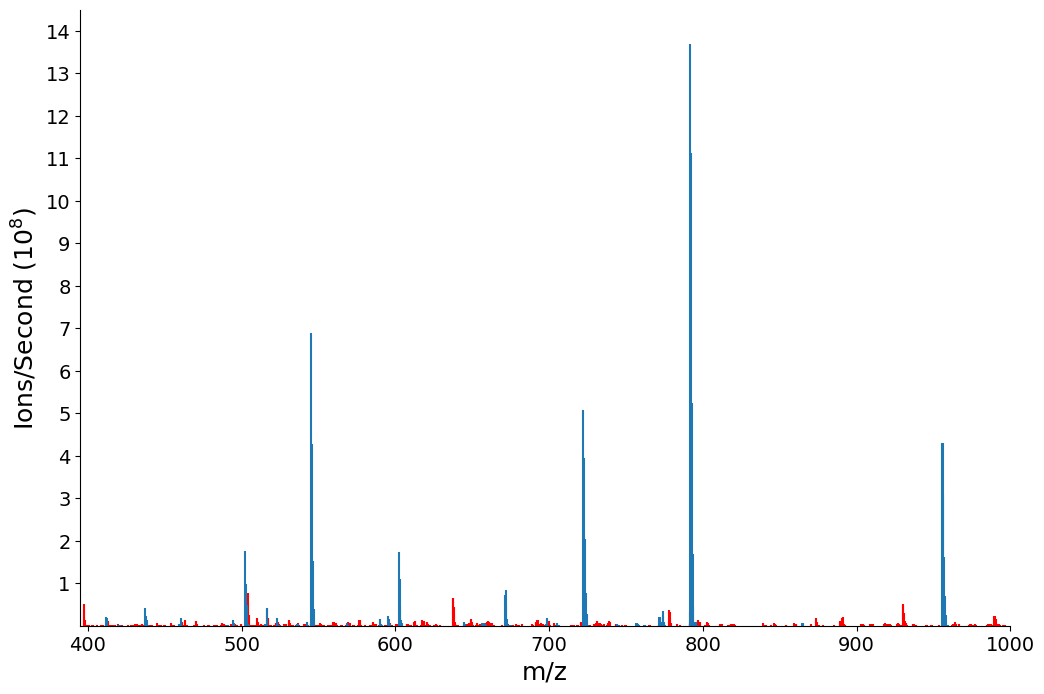

In [295]:
# define figure size
plt.figure(figsize=(12,8))

# plot spectra
plt.vlines(x= noid_ms1_peaks["mz"], ymin = 0, ymax = noid_ms1_peaks["ips"]/1e8, color="red")
plt.vlines(x= id_ms1_peaks["mz"], ymin = 0, ymax = id_ms1_peaks["ips"]/1e8, color="#1f77b4")

# set x-axis parameters
plt.xlabel("m/z", fontsize=18)
plt.xlim(395,1000)
plt.xticks(fontsize=14)

# set y-axis parameters
plt.ylabel("Ions/Second ($10^{8}$)",fontsize=18)
plt.ylim(0,14.5)
plt.yticks(np.arange(1,15,1))
plt.yticks(fontsize=14)

# despine top and right
sns.despine()

# show plot
plt.show()

## Figure (c)

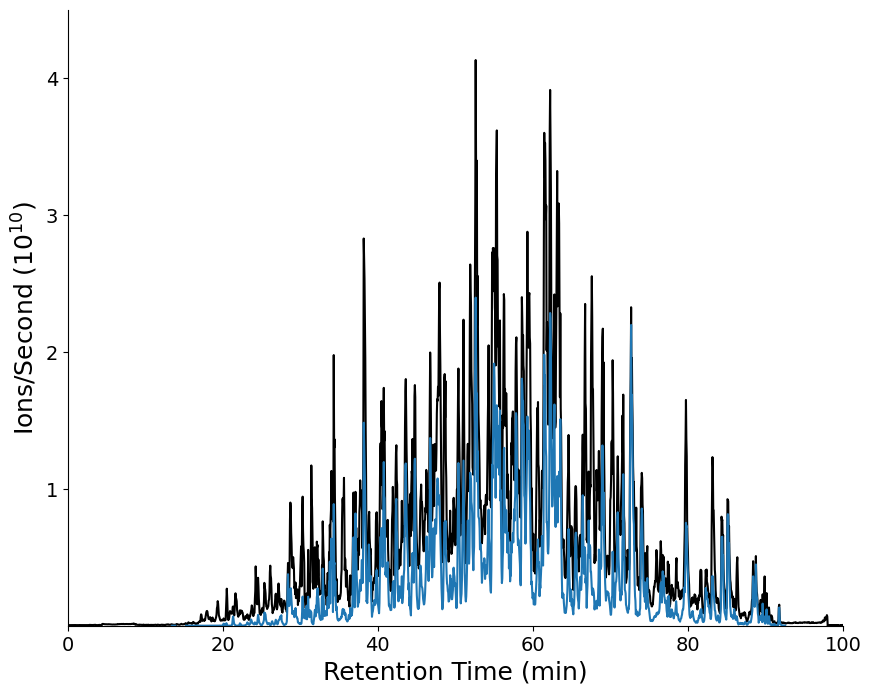

In [64]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize=(10,8))

# make a TIC plot
ax.plot(joined_EV.rt_ms1, joined_EV.TIC_ms1/1e10, color="black")
ax.plot(joined_EV.rt_ms1, joined_EV.TIC_id/1e10, color="#1f77b4")

# set x-axis parameters
ax.set_xlabel("Retention Time (min)", fontsize=18)
ax.set_xlim(0,100)
plt.xticks(fontsize=14)

# set y-axis parameters
ax.set_ylabel("Ions/Second ($10^{10}$)",fontsize=18)
ax.set_ylim(0,4.5)
ax.set_yticks(np.arange(1,5,1))
plt.yticks(fontsize=14)

# despine top and right
sns.despine()

# show plot
plt.show()

## Figure (d)

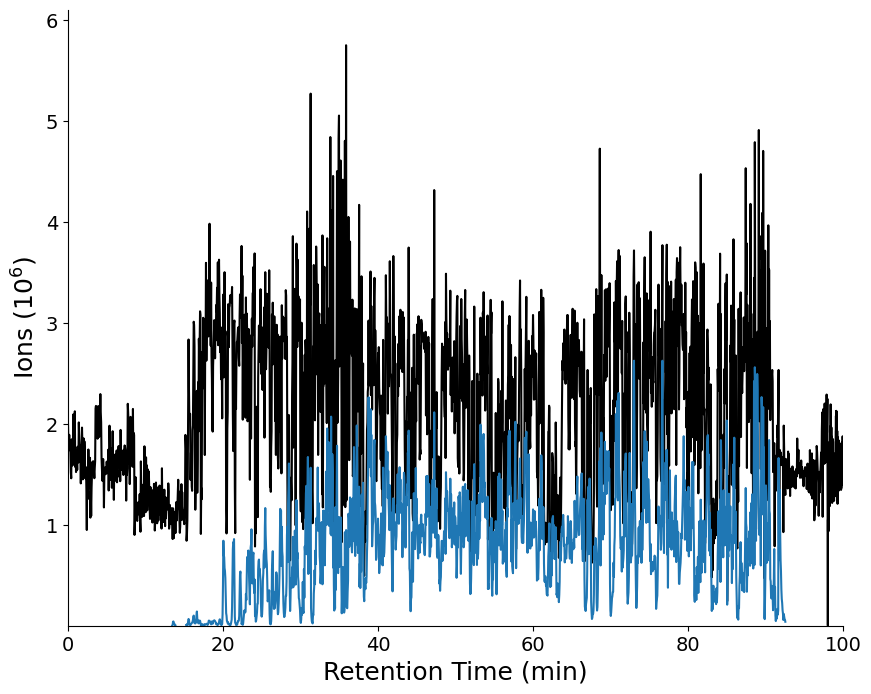

In [70]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize=(10,8))

# make a plot for ion counts
ax.plot(joined_EV.rt_ms1, joined_EV.ions_ms1/1e6, color="black")
ax.plot(joined_EV.rt_ms1, joined_EV.ions_id/1e6, color="#1f77b4")

# set x-axis parameters
ax.set_xlabel("Retention Time (min)", fontsize=18)
ax.set_xlim(0,100)
plt.xticks(fontsize=14)

# set y-axis parameters
ax.set_ylabel("Ions ($10^{6}$)",fontsize=18)
ax.set_ylim(0,6.1)
ax.set_yticks(np.arange(1,7,1))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.yticks(fontsize=14)

# despine top and right
sns.despine()

# show plot
plt.show()